
## Sobhan Asasi
## 400206392




## Install Some necessary libraries

In [1]:
!pip install pycocotools

  Installing build dependencies ... - \ | / - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp37-cp37m-linux_x86_64.whl size=373763 sha256=580f79caeeec3531cd055736a3af083db3a37bce623c69d2faa4ccd978b9e6b3
  Stored in directory: /root/.cache/pip/wheels/06/f6/f9/9cc49c6de8e3cf27dfddd91bf46595a057141d4583a2adaf03
Successfully built pycocotools


In [2]:
!pip install nltk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Requirements

In [3]:
import os 
import sys
from pycocotools.coco import COCO
import urllib
import zipfile 
import math
import pickle

import matplotlib.pyplot as plt 
import skimage.io as io 
import numpy as np 
%matplotlib inline 
from collections import Counter

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
import torch.utils.data as data  



## Download Annotations

In [4]:
annotations_trainval2014 = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip'
image_info_test2014 = 'http://images.cocodataset.org/annotations/image_info_test2014.zip'

urllib.request.urlretrieve(annotations_trainval2014 , filename = 'annotations_trainval2014.zip' )
urllib.request.urlretrieve(image_info_test2014 , filename= 'image_info_test2014.zip' )

('image_info_test2014.zip', <http.client.HTTPMessage at 0x7fb853f1f050>)

In [5]:
trainval_path = '/kaggle/working/annotations_trainval2014.zip'
test_path = '/kaggle/working/image_info_test2014.zip'

with zipfile.ZipFile(trainval_path , 'r') as zip_ref:
  zip_ref.extractall( '/kaggle/working/'  )  

try:
  os.remove( trainval_path )
  print('zip removed')
except:
  None

with zipfile.ZipFile(test_path , 'r') as zip_ref:
  zip_ref.extractall( '/kaggle/working/'  )  

try:
  os.remove( test_path )
  print('zip removed')
except:
  None

zip removed
zip removed


In [6]:
val_instance = '/kaggle/working/annotations/instances_val2014.json'
coco = COCO(val_instance)

# initialize COCO API for caption annotations
val_caption = '/kaggle/working/annotations/captions_val2014.json'
coco_caps = COCO(val_caption)

# get image ids 
ids = list(coco.anns.keys())

loading annotations into memory...
Done (t=5.44s)
creating index...
index created!
loading annotations into memory...
Done (t=0.35s)
creating index...
index created!


http://images.cocodataset.org/val2014/COCO_val2014_000000224850.jpg
Number of annotations i.e captions for the image:  [246999, 253890, 256161, 257199, 258021]

small children amusement ride of cars and trucks
Kids at amusement park riding miniature fire engines.
Children riding a  red fire engine amusement ride.
Two children in a fire truck amusement park ride.
Two children riding on a fire engine carnival ride. 


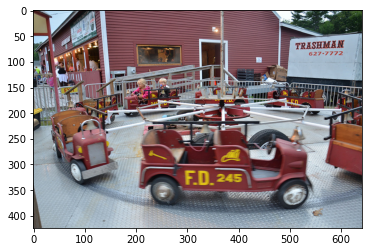

In [7]:
#Pick a random annotation id and display img of that annotation  :
ann_id = np.random.choice( ids )
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs( img_id )[0]
url = img['coco_url']
print(url)
I = io.imread(url)
plt.imshow(I)

# Display captions for that annotation id :
ann_ids = coco_caps.getAnnIds( img_id   )
print('Number of annotations i.e captions for the image: ' , ann_ids)
print()
anns = coco_caps.loadAnns( ann_ids )
coco_caps.showAnns(anns)

## Build Vocabualry for captions

In [8]:
# vocabulary.py -------------------------------------------------------------
import nltk
import pickle
import os.path
from pycocotools.coco import COCO
from collections import Counter

class Vocabulary(object):

    def __init__(self, vocab_threshold, vocab_file='./vocab.pkl', start_word="<start>", end_word="<end>",
        unk_word="<unk>",
        annotations_file='/kaggle/working/annotations/captions_train2014.json',
        vocab_from_file=False):
        """Initialize the vocabulary.
        Args:
          vocab_threshold: Minimum word count threshold.
          vocab_file: File containing the vocabulary.
          start_word: Special word denoting sentence start.
          end_word: Special word denoting sentence end.
          unk_word: Special word denoting unknown words.
          annotations_file: Path for train annotation file.
          vocab_from_file: If False, create vocab from scratch & override any existing vocab_file
                           If True, load vocab from from existing vocab_file, if it exists
        """
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):
        """Load the vocabulary from file OR build the vocabulary from scratch."""
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded from vocab.pkl file!')
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)
        
    def build_vocab(self):
        """Populate the dictionaries for converting tokens to integers (and vice-versa)."""
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        """Initialize the dictionaries for converting tokens to integers (and vice-versa)."""
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        """Add a token to the vocabulary."""
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        """Loop over training captions and add all tokens to the vocabulary that meet or exceed the threshold."""
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, id in enumerate(ids):
            caption = str(coco.anns[id]['caption'])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

## Define loader and dataset

In [9]:
import nltk
import os
import torch
import torch.utils.data as data
from PIL import Image
from pycocotools.coco import COCO
import numpy as np
from tqdm import tqdm
import random
import json

def get_loader(transform, mode='train', batch_size=1, vocab_threshold=None, vocab_file='./vocab.pkl',
               start_word="<start>",
               end_word="<end>",
               unk_word="<unk>",
               vocab_from_file=True,
               num_workers=0):
    """Returns the data loader.
    Args:
      transform: Image transform.
      mode: One of 'train' or 'test'.
      batch_size: Batch size (if in testing mode, must have batch_size=1).
      vocab_threshold: Minimum word count threshold.
      vocab_file: File containing the vocabulary. 
      start_word: Special word denoting sentence start.
      end_word: Special word denoting sentence end.
      unk_word: Special word denoting unknown words.
      vocab_from_file: If False, create vocab from scratch & override any existing vocab_file.
                       If True, load vocab from from existing vocab_file, if it exists.
      num_workers: Number of subprocesses to use for data loading 
    """
    
    assert mode in ['train', 'test'], "mode must be one of 'train' or 'test'."
    if vocab_from_file==False: assert mode=='train', "To generate vocab from captions file, must be in training mode (mode='train')."

    # Based on mode (train, val, test), obtain img_folder and annotations_file.
    if mode == 'train':
        if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        img_folder = '/kaggle/input/coco-2014-dataset-for-yolov3/coco2014/images/train2014'
        annotations_file = '/kaggle/working/annotations/captions_train2014.json'
    if mode == 'test':
        assert batch_size==1, "Please change batch_size to 1 if testing your model."
        assert os.path.exists(vocab_file), "Must first generate vocab.pkl from training data."
        assert vocab_from_file==True, "Change vocab_from_file to True."
        img_folder = '/kaggle/input/coco-2014-dataset-for-yolov3/coco2014/images/test2014'
        annotations_file = '/kaggle/working/annotations/image_info_test2014.json'

    # COCO caption dataset.
    dataset = CoCoDataset(transform=transform, mode=mode, batch_size=batch_size, vocab_threshold=vocab_threshold,
                          vocab_file=vocab_file,
                          start_word=start_word,
                          end_word=end_word,
                          unk_word=unk_word,
                          annotations_file=annotations_file,
                          vocab_from_file=vocab_from_file,
                          img_folder=img_folder)

    if mode == 'train':
        # Randomly sample a caption length, and sample indices with that length.
        indices = dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        # data loader for COCO dataset.
        data_loader = data.DataLoader(dataset=dataset, 
                                      num_workers=num_workers,
                                      batch_sampler=data.sampler.BatchSampler(sampler=initial_sampler,
                                                                              batch_size=dataset.batch_size,
                                                                              drop_last=False))
    else:
        data_loader = data.DataLoader(dataset=dataset,
                                      batch_size=dataset.batch_size,
                                      shuffle=True,
                                      num_workers=num_workers)

    return data_loader

class CoCoDataset(data.Dataset):
    
    def __init__(self, transform, mode, batch_size, vocab_threshold, vocab_file, start_word, 
        end_word, unk_word, annotations_file, vocab_from_file, img_folder):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.vocab = Vocabulary(vocab_threshold, vocab_file, start_word,
            end_word, unk_word, annotations_file, vocab_from_file)
        self.img_folder = img_folder
        if self.mode == 'train':            
            self.coco = COCO(annotations_file)
            self.ids = list(self.coco.anns.keys())
            print('Obtaining caption lengths...')
            all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in tqdm(np.arange(len(self.ids)))]
            self.caption_lengths = [len(token) for token in all_tokens]
        else:
            test_info = json.loads(open(annotations_file).read())
            self.paths = [item['file_name'] for item in test_info['images']]
        
    def __getitem__(self, index):
        # obtain image and caption if in training mode
        if self.mode == 'train':
            ann_id = self.ids[index]
            caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            path = self.coco.loadImgs(img_id)[0]['file_name']

            # Convert image to tensor and pre-process using transform
            image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            image = self.transform(image)

            # Convert caption to tensor of word ids.
            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(self.vocab(self.vocab.start_word))
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
            caption = torch.Tensor(caption).long()

            # return pre-processed image and caption tensors
            return image, caption

        # obtain image if in test mode
        else:
            path = self.paths[index]

            # Convert image to tensor and pre-process using transform
            PIL_image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            orig_image = np.array(PIL_image)
            image = self.transform(PIL_image)

            # return original image and pre-processed image tensor
            return orig_image, image

    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        if self.mode == 'train':
            return len(self.ids)
        else:
            return len(self.paths)

In [10]:
# Define a transform to pre-process the training images.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Set the minimum word count threshold.
vocab_threshold = 8

# Specify the batch size.
batch_size = 200

# Obtain the data loader.
data_loader_train = get_loader(transform=transform_train, mode='train', batch_size=batch_size,vocab_threshold=vocab_threshold,
                         vocab_from_file=False)

loading annotations into memory...
Done (t=0.68s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=0.67s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:45<00:00, 9024.90it/s]


In [11]:
# Lets check word2idx in vocb 
print('First few vocab' , dict(list(data_loader_train.dataset.vocab.word2idx.items())[:10]))
# Print the total number of keys in the word2idx dictionary.
print('Total number of tokens in vocabulary:', len(data_loader_train.dataset.vocab))

First few vocab {'<start>': 0, '<end>': 1, '<unk>': 2, 'a': 3, 'very': 4, 'clean': 5, 'and': 6, 'well': 7, 'decorated': 8, 'empty': 9}
Total number of tokens in vocabulary: 7072


In [12]:
counter = Counter(data_loader_train.dataset.caption_lengths)
lengths = sorted( counter.items() , key = lambda pair : pair[1] , reverse=True )
for val,count in lengths:
  print( 'value %2d  count %5d' %(val,count) )
  if count < 10000: 
    break

value 10  count 86302
value 11  count 79971
value  9  count 71920
value 12  count 57653
value 13  count 37668
value 14  count 22342
value  8  count 20742
value 15  count 12839
value 16  count  7736


In [13]:
# Randomly sample a caption length, and sample indices with that length.
indices = data_loader_train.dataset.get_train_indices()
print('Sample Indices:' , indices )

# Create and assign a batch sampler to retrieve a batch with the sampled indices.
sampler = data.sampler.SubsetRandomSampler(  indices )
data_loader_train.batch_sampler.sampler = sampler 

# obtain images, caption :
images , captions = next(iter(data_loader_train))
print(images.shape , captions.shape)

Sample Indices: [376816, 264388, 76864, 145607, 378514, 179502, 14857, 164136, 265954, 371125, 1027, 55317, 160325, 278033, 183739, 215542, 234081, 19718, 220668, 122620, 130865, 139463, 81527, 78013, 228908, 124577, 45818, 376570, 153847, 49923, 301876, 353959, 149081, 409131, 71105, 87822, 179751, 373121, 110436, 261670, 400945, 376466, 347990, 262531, 314171, 137897, 177969, 380739, 139017, 82794, 168989, 136522, 112101, 73193, 166041, 180872, 80596, 355228, 306401, 201878, 194913, 175452, 269989, 409522, 290401, 205289, 413512, 211253, 274279, 21989, 19098, 85520, 122852, 38058, 63217, 164891, 23650, 117044, 197322, 276362, 132892, 66854, 86940, 398357, 261635, 327603, 29418, 130982, 229520, 133728, 41523, 172929, 267098, 187527, 397222, 272205, 376409, 106016, 199028, 179301, 196749, 267839, 357274, 304813, 34215, 296318, 25931, 2697, 370654, 153744, 208006, 366942, 129456, 135119, 283653, 152002, 235139, 391104, 319735, 90587, 355232, 170761, 279483, 96209, 407959, 15647, 215980,

In [14]:
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)        
        features = features.view(features.size(0), -1)        
        features = self.embed(features)        
        return features

In [16]:
# specify dim of image embedding
embed_size = 256 
encoder = EncoderCNN( embed_size )
encoder.to(device)
images =  images.to(device) # images from step2 
features = encoder(images)

print(type(features) , features.shape , images.shape)
assert( type(features) == torch.Tensor )  , 'Encoder output should be pytorch tensor'
assert (features.shape[0] == batch_size) & (features.shape[1] == embed_size) , "The shape of the encoder output is incorrect."

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

<class 'torch.Tensor'> torch.Size([200, 256]) torch.Size([200, 3, 224, 224])


In [17]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super( DecoderRNN , self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size 
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.word_embedding = nn.Embedding( self.vocab_size , self.embed_size )
        self.lstm  = nn.LSTM(    input_size  =  self.embed_size , 
                             hidden_size = self.hidden_size,
                             num_layers  = self.num_layers ,
                             batch_first = True 
                             )
        self.fc = nn.Linear( self.hidden_size , self.vocab_size  )
        

    def init_hidden( self, batch_size ):
      return ( torch.zeros( self.num_layers , batch_size , self.hidden_size  ).to(device),
      torch.zeros( self.num_layers , batch_size , self.hidden_size  ).to(device) )
    
    def forward(self, features, captions):            
      captions = captions[:,:-1]      
      self.batch_size = features.shape[0]
      self.hidden = self.init_hidden( self.batch_size )
      embeds = self.word_embedding( captions )
      inputs = torch.cat( ( features.unsqueeze(dim=1) , embeds ) , dim =1  )      
      lstm_out , self.hidden = self.lstm(inputs , self.hidden)      
      outputs = self.fc( lstm_out )      
      return outputs

    def Predict(self, inputs, max_len=20):        
        final_output = []
        batch_size = inputs.shape[0]         
        hidden = self.init_hidden(batch_size) 
    
        while True:
            lstm_out, hidden = self.lstm(inputs, hidden) 
            outputs = self.fc(lstm_out)  
            outputs = outputs.squeeze(1) 
            _, max_idx = torch.max(outputs, dim=1) 
            final_output.append(max_idx.cpu().numpy()[0].item())             
            if (max_idx == 1 or len(final_output) >=20 ):
                break
            
            inputs = self.word_embedding(max_idx) 
            inputs = inputs.unsqueeze(1)             
        return final_output  

In [18]:
embed_size = 256
hidden_size = 100
num_layers = 1 
num_epochs = 3
print_every = 200
save_every = 1 
vocab_size = len(data_loader_train.dataset.vocab)
total_step = math.ceil( len(data_loader_train.dataset.caption_lengths) / data_loader_train.batch_sampler.batch_size   )


decoder = DecoderRNN(  embed_size , hidden_size, vocab_size ,num_layers)
criterion = nn.CrossEntropyLoss()
lr = 0.001
all_params = list(decoder.parameters())  + list( encoder.embed.parameters() )
optimizer = torch.optim.Adam( params  = all_params , lr = lr  )

## Train Loop

In [19]:
for epoch in range(num_epochs):
  for step in range(total_step):
    indices = data_loader_train.dataset.get_train_indices()
    new_sampler = data.sampler.SubsetRandomSampler( indices )
    data_loader_train.batch_sampler.sampler = new_sampler    
    images,captions = next(iter(data_loader_train))    
    images , captions = images.to(device) , captions.to(device)
    encoder , decoder = encoder.to(device) , decoder.to(device)
    encoder.zero_grad()    
    decoder.zero_grad()
    features = encoder(images)
    output = decoder( features , captions )    
    loss = criterion( output.view(-1, vocab_size) , captions.view(-1) )
    loss.backward()
    optimizer.step()
    stat_vals = 'Epochs [%d/%d] Step [%d/%d] Loss [%.4f] ' %( epoch+1,num_epochs,step,total_step,loss.item() )
    if step % print_every == 0 :
      print(stat_vals)
      sys.stdout.flush()

Epochs [1/3] Step [0/2071] Loss [8.8587] 
Epochs [1/3] Step [200/2071] Loss [3.7447] 
Epochs [1/3] Step [400/2071] Loss [3.3849] 
Epochs [1/3] Step [600/2071] Loss [3.4934] 
Epochs [1/3] Step [800/2071] Loss [3.1526] 
Epochs [1/3] Step [1000/2071] Loss [2.9187] 
Epochs [1/3] Step [1200/2071] Loss [3.2761] 
Epochs [1/3] Step [1400/2071] Loss [2.9196] 
Epochs [1/3] Step [1600/2071] Loss [2.7699] 
Epochs [1/3] Step [1800/2071] Loss [2.7926] 
Epochs [1/3] Step [2000/2071] Loss [2.6826] 
Epochs [2/3] Step [0/2071] Loss [2.7303] 
Epochs [2/3] Step [200/2071] Loss [2.6501] 
Epochs [2/3] Step [400/2071] Loss [2.8085] 
Epochs [2/3] Step [600/2071] Loss [2.5120] 
Epochs [2/3] Step [800/2071] Loss [2.5939] 
Epochs [2/3] Step [1000/2071] Loss [2.7192] 
Epochs [2/3] Step [1200/2071] Loss [2.5545] 
Epochs [2/3] Step [1400/2071] Loss [3.2249] 
Epochs [2/3] Step [1600/2071] Loss [2.4725] 
Epochs [2/3] Step [1800/2071] Loss [2.5313] 
Epochs [2/3] Step [2000/2071] Loss [2.8890] 
Epochs [3/3] Step [0/207

In [20]:
from torchvision import transforms

# Define a transform to pre-process the training images.
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Obtain the data loader.
data_loader_test = get_loader(transform=transform_test,mode='test')

data_iter = iter(data_loader_test)

Vocabulary successfully loaded from vocab.pkl file!


## Test Image 

In [21]:
def get_sentences( original_img, all_predictions ):
  sentence = ' '
  plt.imshow(original_img.squeeze())
  return sentence.join([data_loader_test.dataset.vocab.idx2word[idx] for idx in all_predictions[1:-1] ] )

'a man riding a skateboard down a street .'

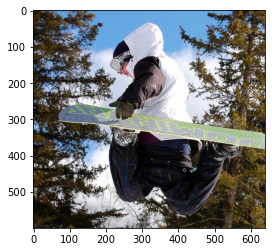

In [22]:
encoder.to(device) 
decoder.to(device)
encoder.eval()
decoder.eval()
original_img , processed_img  = next(data_iter)

features  = encoder(processed_img.to(device)).unsqueeze(1)
final_output = decoder.Predict( features  , max_len=20)
get_sentences(original_img, final_output)